In [19]:
import os
import time
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from src.models import load_model
from src.visualization import process_image, load_and_transform_image_mask, get_heatmap, show_mask_on_image
from evaluate_seg import compute_bce_with_logits_mask


## Warnings
import warnings
warnings.filterwarnings("ignore", message="Clipping input data to the valid range")


In [3]:
from hydra import initialize, compose
from omegaconf import OmegaConf
import torch
from src.models import load_model

# 🌀 Setup Hydra manually
with initialize(version_base=None, config_path="config"):
    cfg = compose(config_name="config", overrides=["data=config7", "model=resnet", "model.weight_path=checkpoints/resnet_8_30_7.pth"])

# Tu peux afficher la config complète si besoin :
# print(OmegaConf.to_yaml(cfg))

# 🧠 Charger le modèle une fois
cfg.load_model = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = load_model(cfg.model.name, device, cfg.model).eval()
print(f"✅ Model loaded: {cfg.model.name}")

Loading weights from checkpoints/resnet_8_30_7.pth
✅ Model loaded: resnet


In [4]:

print(f"[Notebook] Model loaded: {cfg.model.name}")

# ── Choose image(s) to visualize ─────────────────────
image_dir = cfg.data.test_original_path
mask_dir = cfg.data.test_mask_path
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])

[Notebook] Model loaded: resnet


In [7]:
image_dir = cfg.data.test_original_path
mask_dir = cfg.data.test_mask_path
numbers = [5,]
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])


Processing Plot_13.png
model is on device cuda:0
0.7018463015556335
[timer] Plot_13.png took 1.58


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


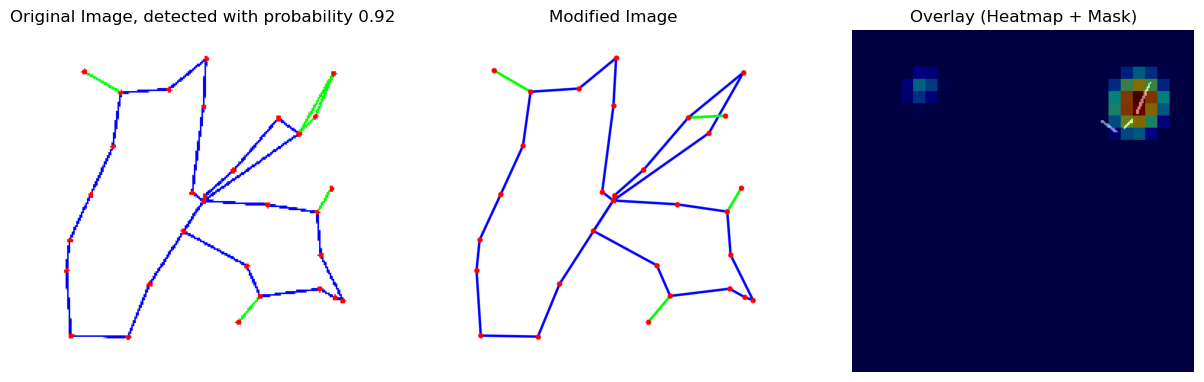


Processing Plot_17.png
model is on device cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


0.7036522030830383
[timer] Plot_17.png took 0.21


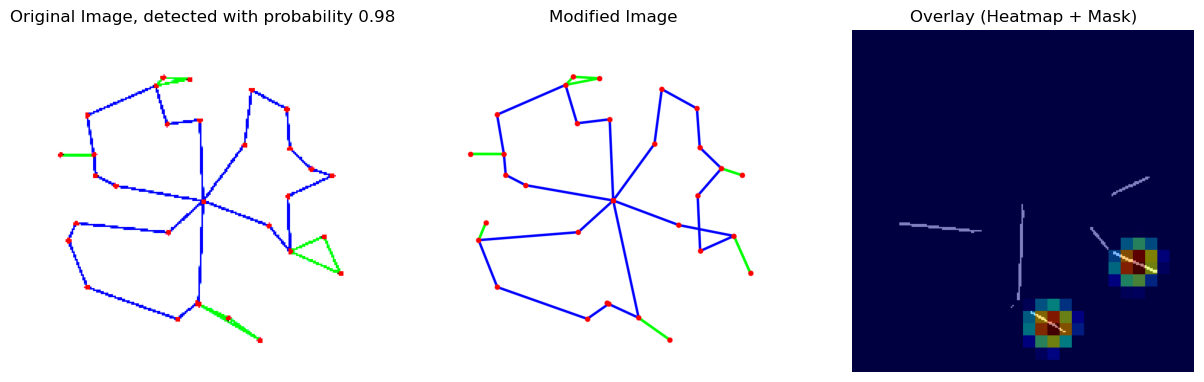


Processing Plot_18.png
model is on device cuda:0
0.7025080919265747
[timer] Plot_18.png took 0.19


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


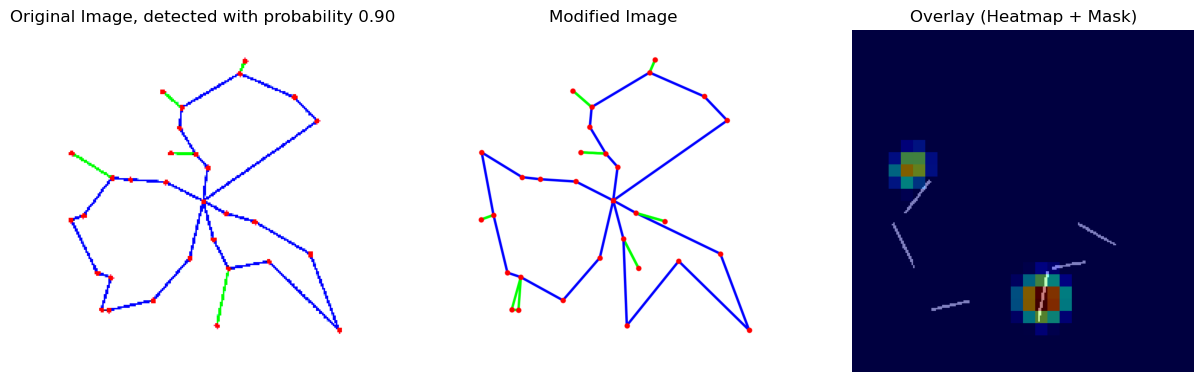


Processing Plot_30.png
model is on device cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


0.7033676505088806
[timer] Plot_30.png took 0.25


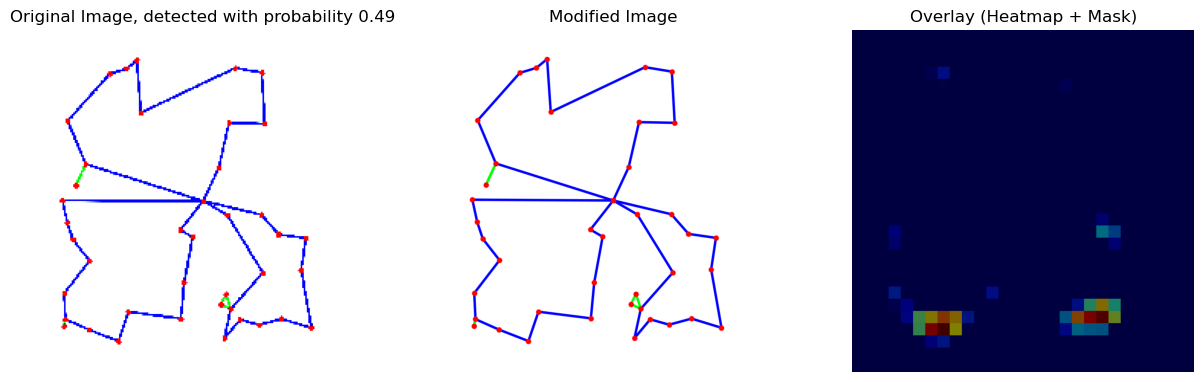


Processing Plot_36.png
model is on device cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


0.6981417536735535
[timer] Plot_36.png took 0.24


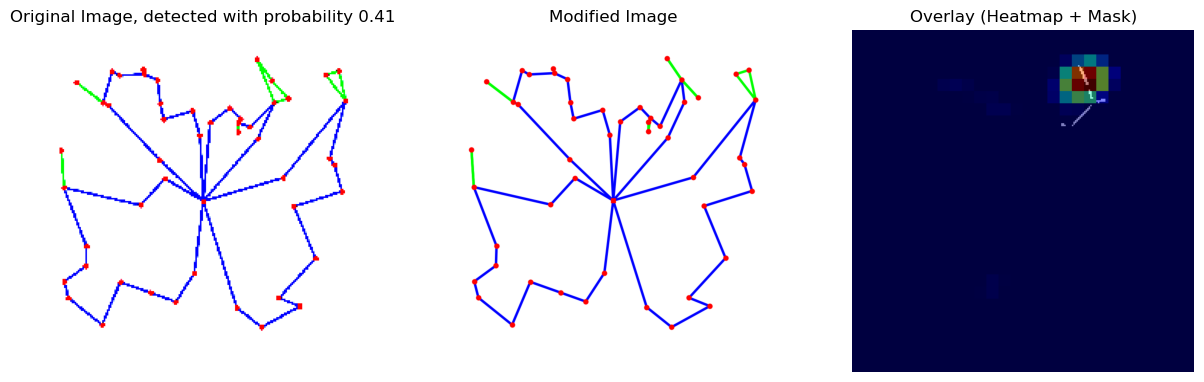


Processing Plot_38.png
model is on device cuda:0
0.7022484540939331
[timer] Plot_38.png took 0.20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


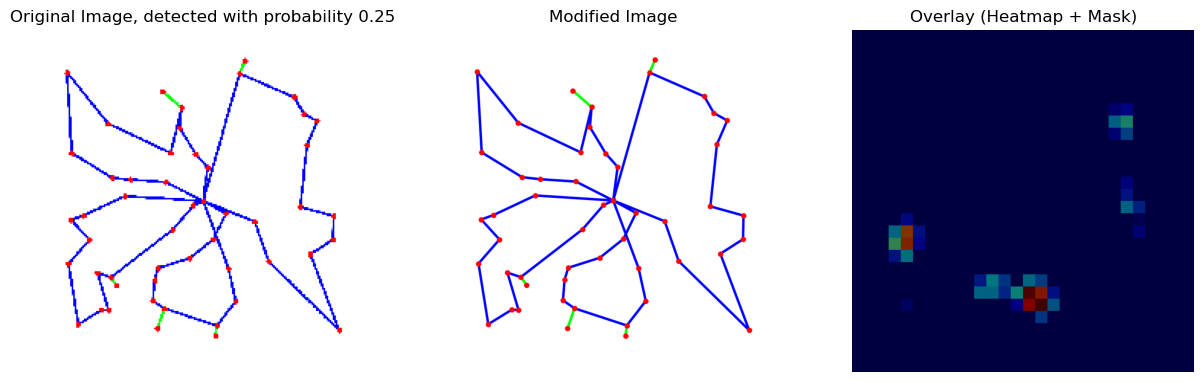


Processing Plot_43.png
model is on device cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


0.7020624279975891
[timer] Plot_43.png took 0.27


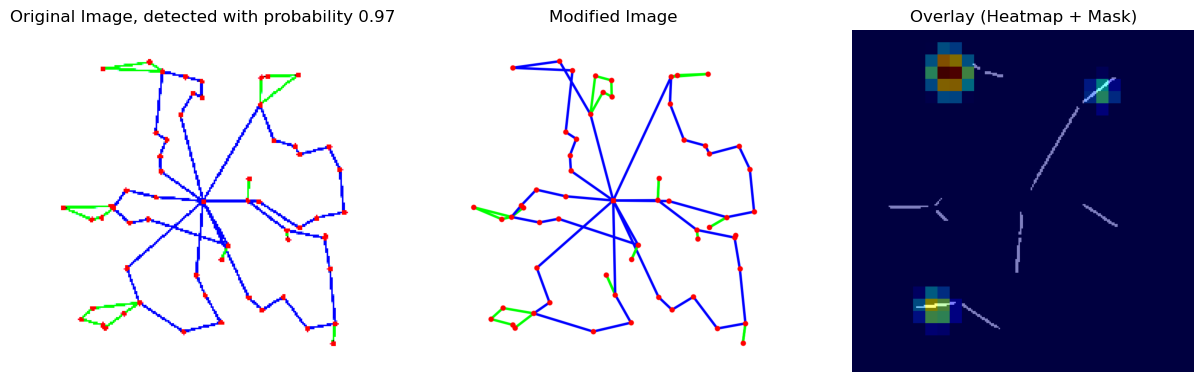


Processing Plot_49.png
model is on device cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


0.7030192613601685
[timer] Plot_49.png took 0.25


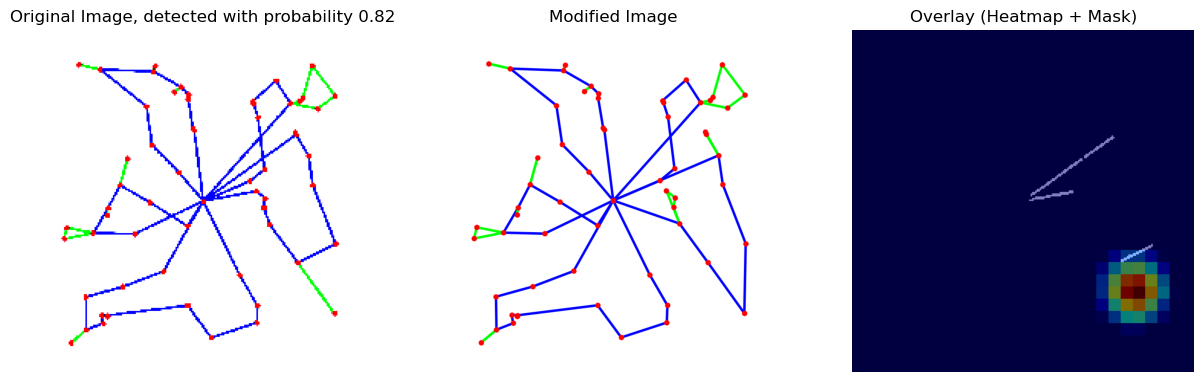


Processing Plot_5.png
model is on device cuda:0
0.6992399096488953
[timer] Plot_5.png took 0.20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


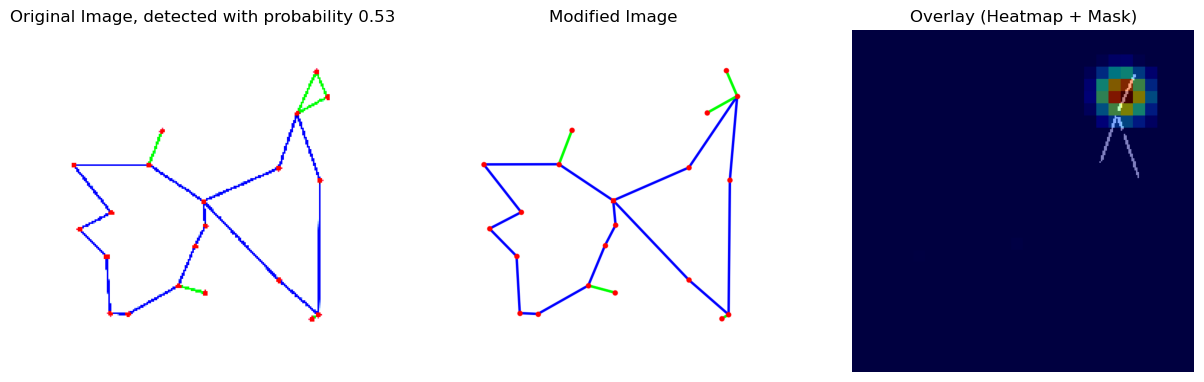


Processing Plot_58.png
model is on device cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


0.7003771662712097
[timer] Plot_58.png took 0.41


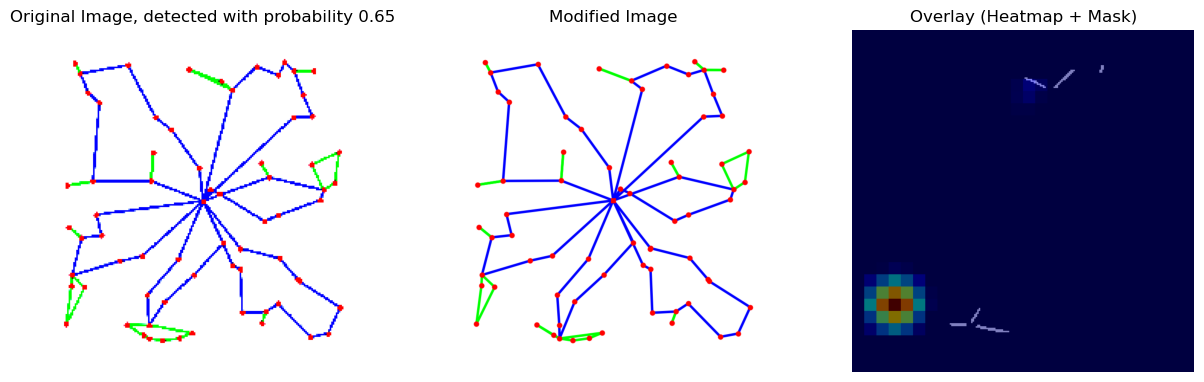

In [23]:
for fname in image_files[:10]:  # change to [0] or other slice to limit
    print(f"\nProcessing {fname}")
    start = time.perf_counter()

    # Load image and mask
    t_img, mask = load_and_transform_image_mask(cfg, fname, device)

    modified_image_path = os.path.join(cfg.data.test_modified_path, fname)  
    modified_img = Image.open(modified_image_path).convert("RGB")
    
    
    
    # Compute heatmap
    heatmap = get_heatmap(cfg.heatmap.method, model, t_img, cfg.heatmap.args, device=device)
    prediction = model(t_img.to(device))
    pred_probab = torch.sigmoid(prediction).squeeze().cpu()[1]

    # Overlay image
    overlay = show_mask_on_image(mask, heatmap, alpha=0.5, interpolation=cv2.INTER_NEAREST)

    # Compute loss
    loss = compute_bce_with_logits_mask(heatmap, mask)
    print(loss)
    print(f"[timer] {fname} took {time.perf_counter() - start:.2f}")
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(t_img.squeeze(0).permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Original Image, detected with probability {:.2f}".format(pred_probab.item()))
    axs[1].imshow(modified_img)
    axs[1].set_title("Modified Image")
    axs[2].imshow(overlay)
    axs[2].set_title("Overlay (Heatmap + Mask)")


    for ax in axs:
        ax.axis("off")
    plt.show()